In [9]:
import nilearn
from nilearn import datasets, plotting, image
import os
import requests
import csv
import pandas as pd
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt

## Load data and get ROIs, save pooled subject timeseries

In [2]:
whole_path = 'atlases/HarvardOxford/fsl/data/atlases/HarvardOxford'
# fetch different atlases
whole_data = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm', data_dir=whole_path)
msdl_data = datasets.fetch_atlas_msdl()
#cereb_data = nib.load('Cerebellum-MNIsegment-1segment.nii')


msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print(
    f"MSDL has {n_regions} ROIs, "
    f"part of the following networks:\n{msdl_data.networks}."
)


[get_dataset_dir] Dataset found in atlases/HarvardOxford/fsl/data/atlases/HarvardOxford/fsl
[get_dataset_dir] Dataset found in /Users/ajjain/nilearn_data/msdl_atlas
MSDL has 39 ROIs, part of the following networks:
['Aud', 'Aud', 'Striate', 'DMN', 'DMN', 'DMN', 'DMN', 'Occ post', 'Motor', 'R V Att', 'R V Att', 'R V Att', 'R V Att', 'Basal', 'L V Att', 'L V Att', 'L V Att', 'D Att', 'D Att', 'Vis Sec', 'Vis Sec', 'Vis Sec', 'Salience', 'Salience', 'Salience', 'Temporal', 'Temporal', 'Language', 'Language', 'Language', 'Language', 'Language', 'Cereb', 'Dors PCC', 'Cing-Ins', 'Cing-Ins', 'Cing-Ins', 'Ant IPS', 'Ant IPS'].


In [7]:
msdl_data.labels

['L Aud',
 'R Aud',
 'Striate',
 'L DMN',
 'Med DMN',
 'Front DMN',
 'R DMN',
 'Occ post',
 'Motor',
 'R DLPFC',
 'R Front pol',
 'R Par',
 'R Post Temp',
 'Basal',
 'L Par',
 'L DLPFC',
 'L Front pol',
 'L IPS',
 'R IPS',
 'L LOC',
 'Vis',
 'R LOC',
 'D ACC',
 'V ACC',
 'R A Ins',
 'L STS',
 'R STS',
 'L TPJ',
 'Broca',
 'Sup Front S',
 'R TPJ',
 'R Pars Op',
 'Cereb',
 'Dors PCC',
 'L Ins',
 'Cing',
 'R Ins',
 'L Ant IPS',
 'R Ant IPS']

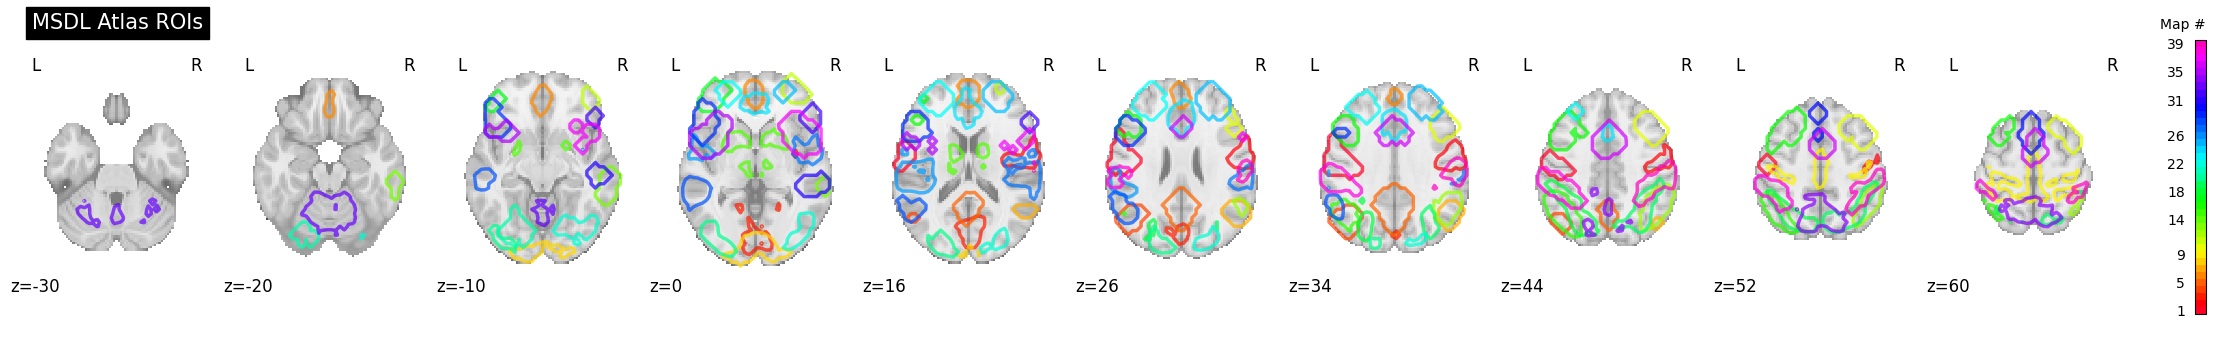

In [8]:
# Plot the ROIs
plotting.plot_prob_atlas(msdl_data.maps, title='MSDL Atlas ROIs', display_mode='z', cut_coords=10, colorbar=True)
plotting.show()

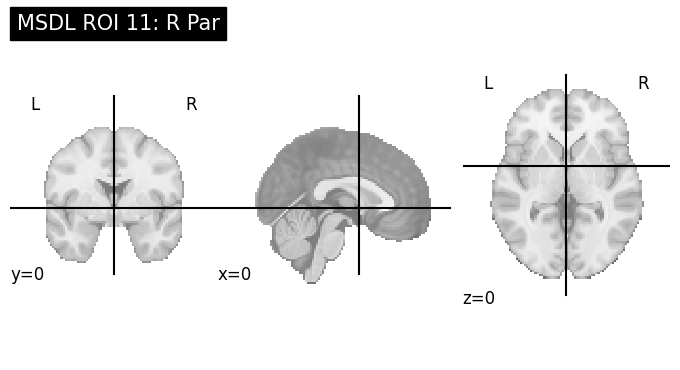

In [11]:
atlas_niimg = msdl_data.maps  # this is a 4D Nifti image (each volume = one ROI)
labels = msdl_data.labels     # list of ROI names

# Choose an ROI index (e.g., ROI 5)
roi_index = 11
roi_label = labels[roi_index]

# Extract that ROI as a 3D image
roi_img = image.index_img(atlas_niimg, roi_index)

# Plot it
plotting.plot_roi(roi_img, title=f"MSDL ROI {roi_index}: {roi_label}",
                  display_mode='ortho', cmap='autumn', cut_coords=(0, 0, 0))
plotting.show()

In [5]:
from nilearn.maskers import NiftiMapsMasker, NiftiLabelsMasker

cort_masker = NiftiMapsMasker(
    msdl_data.maps,
    resampling_target="data",
    t_r=2,
    detrend=True,
    low_pass=0.1,
    high_pass=0.01,
    memory="nilearn_cache",
    memory_level=1,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
).fit()

# Instantiate the masker with label image and label values
whole_masker = NiftiLabelsMasker(
        whole_data.maps,
        labels=whole_data.labels,
        resampling_target="data",
        t_r=2,
        detrend=True,
        standardize="zscore_sample",
    ).fit()

cereb_masker = NiftiMapsMasker(
    'Cerebellum-MNIsegment-1segment.nii',
    resampling_target="data",
    t_r=2,
    detrend=True,
    low_pass=0.1,
    high_pass=0.01,
    memory="nilearn_cache",
    memory_level=1,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
).fit

In [6]:
# Base URL for the dataset
base_url = "/mfs/io/groups/dmello/projects/dynamric/tree_mri/datasets/abide/preprocessed_dataset/Outputs/dparsf/filt_noglobal/func_preproc"

# Function to construct the download URL
def construct_url(base_url, file_id):
    return f"{base_url}/{file_id}_func_preproc.nii.gz"

s3_pheno_file = "/mfs/io/groups/dmello/projects/dynamric/tree_mri/datasets/abide/Phenotypic_V1_0b_preprocessed1.csv"

pheno_data = pd.read_csv(s3_pheno_file)

pheno_data

FileNotFoundError: [Errno 2] No such file or directory: '/mfs/io/groups/dmello/projects/dynamric/tree_mri/datasets/abide/Phenotypic_V1_0b_preprocessed1.csv'

In [13]:
abide_files = os.listdir(base_url)
len(abide_files)

884

In [14]:
abide_ids = []
phenotype = []

for i in range(len(pheno_data)):
    file_id = pheno_data['FILE_ID'][i]
    dx = pheno_data['DX_GROUP'][i]
    url = f'{file_id}_func_preproc.nii.gz'
    if url in abide_files: 
        abide_ids.append(file_id)
        if dx == 1: phenotype.append(1) # autism diagnosis
        else: phenotype.append(0) # tdc

In [15]:
# Load the NIfTI file
test_url = construct_url(base_url, abide_ids[0])
img = nib.load(test_url)

# Get the image data as a NumPy array
img_data = img.get_fdata()

print(img_data.shape)
print(img_data)

(61, 73, 61, 195)
[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.000000

In [16]:
# get pooled subject time series based on the atlas rois
def get_pooled(abide_ids, phenotype, masker):
    pooled_subjects = []

    for func_file, phenotypic in zip(
        abide_ids[:30],
        phenotype[:30],
    ):
        time_series = masker.transform(construct_url(base_url, func_file))
        pooled_subjects.append(time_series)
    
    return pooled_subjects

In [24]:
whole_pooled = get_pooled(abide_ids, phenotype, whole_masker)

In [26]:
np.array(whole_pooled).shape

(30, 195, 21)

In [25]:
np.array(whole_pooled).shape
whole_pooled = np.array(whole_pooled)
whole_2d = whole_pooled.reshape(whole_pooled.shape[0], -1)
np.savetxt('abide_30_harvard_oxford_pooled.csv', whole_2d , delimiter=',')
np.savetxt('abide_30_harvard_oxford_pooled_3d_shape.csv', whole_pooled.shape, delimiter=',')

In [ ]:
# only need to run to produce csv

'''
# get pooled subject time series
cort_pooled = get_pooled(abide_ids, phenotype, cort_masker)
cereb_pooled = get_pooled(abide_ids, phenotype, cereb_masker)
whole_pooled = get_pooled(abide_ids, phenotype, whole_masker)

# convert to np array
cort_pooled = np.array(cort_pooled)
cereb_pooled = np.array(cereb_pooled)
whole_pooled = np.array(whole_pooled)

# Save the arrays and shapes to a CSV file
cort_2d = cort_pooled.reshape(cort_pooled.shape[0], -1)
cereb_2d = cereb_pooled.reshape(cereb_pooled.shape[0], -1)
whole_2d = whole_pooled.reshape(whole_pooled.shape[0], -1)

np.savetxt('abide_30_msdl_pooled.csv', cort_2d , delimiter=',')
np.savetxt('abide_30_diedrichsen_pooled.csv', cereb_2d , delimiter=',')
np.savetxt('abide_30_harvard_oxford_pooled.csv', whole_2d , delimiter=',')

np.savetxt('abide_30_msdl_pooled_3d_shape.csv', cort_pooled.shape, delimiter=',')
np.savetxt('abide_30_diedrichsen_pooled_3d_shape.csv', cereb_pooled.shape, delimiter=',')
np.savetxt('abide_30_harvard_oxford_pooled_3d_shape.csv', whole_pooled.shape, delimiter=',')

'''


In [28]:
# load 3d shapes
cort_shape = np.loadtxt('abide_30_msdl_pooled_3d_shape.csv', delimiter=',').astype(int)
cereb_shape = np.loadtxt('abide_30_diedrichsen_pooled_3d_shape.csv', delimiter=',').astype(int)
whole_shape = np.loadtxt('abide_30_harvard_oxford_pooled_3d_shape.csv', delimiter=',').astype(int)

# load and reshape pooled time series
cort_pooled = np.loadtxt('abide_30_msdl_pooled.csv', delimiter=',').reshape(cort_shape)
cereb_pooled = np.loadtxt('abide_30_diedrichsen_pooled.csv', delimiter=',').reshape(cereb_shape)
whole_pooled = np.loadtxt('abide_30_harvard_oxford_pooled.csv', delimiter=',').reshape(whole_shape)

In [91]:
whole_pooled.shape

(30, 195, 1)